In [1]:
from helpers import *
import matplotlib.pyplot as plt
import os, glob, cv2, random
import seaborn as sns
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# Preview

In [15]:
path = "./dataset/"

# 학습 데이터 준비 
filenames = os.listdir(path)
X=[]
y=[]
categories=[]
for filename in filenames:
    image = Image.open(path + filename)
    
    image = np.array(image)
    X.append(image)
    category=filename.split("_")[0]
    if category =="close":
        y.append([0])
    else:
        y.append([1])

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
X.shape, y.shape

((44, 26, 34), (44, 1))

In [22]:
n_total = len(X)
X_result = np.empty((n_total, 26, 34,1))

In [23]:
for i, x in enumerate(X):
    img = x.reshape((26, 34,1))
    
    X_result[i] = img

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_result, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

np.save('dataset/x_train.npy', x_train)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/x_val.npy', x_val)
np.save('dataset/y_val.npy', y_val)

(39, 26, 34, 1) (39, 1)
(5, 26, 34, 1) (5, 1)


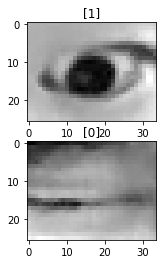

In [28]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[3]))
plt.imshow(x_val[3].reshape((26, 34)), cmap='gray')

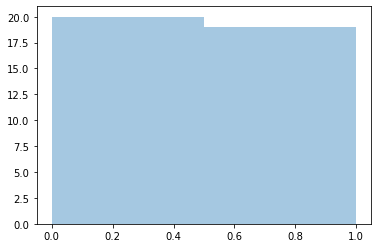

In [26]:
sns.distplot(y_train, kde=False)

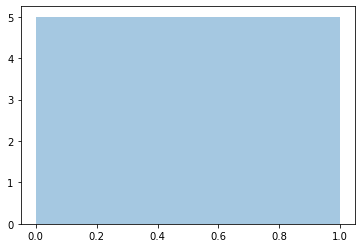

In [27]:
sns.distplot(y_val, kde=False)

In [29]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [30]:
x_train = np.load('dataset/x_train.npy').astype(np.float32)
y_train = np.load('dataset/y_train.npy').astype(np.float32)
x_val = np.load('dataset/x_val.npy').astype(np.float32)
y_val = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(39, 26, 34, 1) (39, 1)
(5, 26, 34, 1) (5, 1)


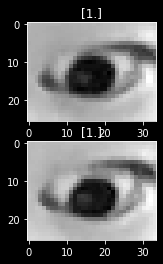

In [31]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [33]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [36]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('./gaze_tracking/trained_models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1712 - acc: 0.9375
Epoch 00001: val_acc improved from -inf to 1.00000, saving model to models/2021_07_11_20_43_10.h5
2/2 [==============================] - 0s 44ms/step - loss: 0.1655 - acc: 0.9487 - val_loss: 0.0264 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1036 - acc: 1.0000
Epoch 00002: val_acc did not improve from 1.00000
2/2 [==============================] - 0s 30ms/step - loss: 0.1106 - acc: 1.0000 - val_loss: 0.0262 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1241 - acc: 1.0000
Epoch 00003: val_acc did not improve from 1.00000
2/2 [==============================] - 0s 35ms/step - loss: 0.1015 - acc: 0.9744 - val_loss: 0.0260 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 4/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1828 - acc: 0.8571
Epoch 00004: val_acc did not improve from 1.00000

Epoch 31/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1128 - acc: 0.9688
Epoch 00031: val_acc did not improve from 1.00000
2/2 [==============================] - 0s 25ms/step - loss: 0.1440 - acc: 0.9487 - val_loss: 0.0223 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 32/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1266 - acc: 1.0000
Epoch 00032: val_acc did not improve from 1.00000
2/2 [==============================] - 0s 36ms/step - loss: 0.1377 - acc: 0.9487 - val_loss: 0.0223 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 33/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0571 - acc: 1.0000
Epoch 00033: val_acc did not improve from 1.00000
2/2 [==============================] - 0s 34ms/step - loss: 0.0772 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 34/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1121 - acc: 0.9688
Epoch 00034: val_acc did not improve from 1.00000
2/2 [==============================] - 0s 2

test acc: 1.0


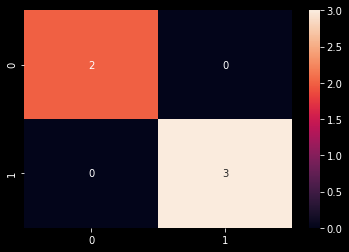

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

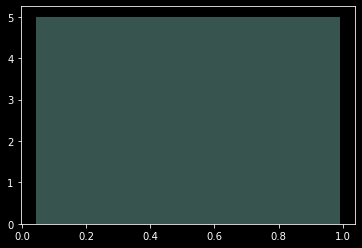

In [38]:
ax = sns.distplot(y_pred, kde=False)

# Preprocessing

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=validation_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

In [ ]:
n_total = len(X)
X_result = np.empty((n_total, 26, 34, 1))

for i, x in enumerate(X):
    img = x.reshape((26, 34, 1))
    
    X_result[i] = img

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_result, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

np.save('dataset/x_train.npy', x_train)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/x_val.npy', x_val)
np.save('dataset/y_val.npy', y_val)

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [ ]:
sns.distplot(y_train, kde=False)

In [ ]:
sns.distplot(y_val, kde=False)